# Imports

In [7]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
from cv_helper import CvHelper

# Constants
## For styling

In [8]:
colors = [(0,127,255), (127,0,255), (0,127,0), (255,0,0)]
line_padding = [0.7, 1.5,1.5,1.5]

font_scale = 1
text_position_cnt = (100, 100)
text_position_time = (100, 120)

output_folder_video = "../output/video"
output_folder_csv = "../output/csv"

## For algorithm tuning

In [9]:
# Are for optime
kernel = np.ones((5,5),np.uint8)
threshold_area_size = [100, 150, 100, 10]
video_name = "010_001_test"
video_path = f"../{video_name}.mp4"
frame_shift = 500
set_fps = 150 # I dont know if its work



In [10]:
video_path

'../010_001_test.mp4'

## Support functions

In [11]:
# Add text overlay into video frame
def add_text_to_frame(frame, text, position=(30, 30), font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.2, color=(0, 255, 0), thickness=2):
    """
    Add text to a frame.

    Parameters:
    - frame (numpy.ndarray): Input frame.
    - text (str): Text to be added to the frame.
    - position (tuple): Position of the text (x, y).
    - font (int): Font type.
    - font_scale (float): Font scale.
    - color (tuple): Text color (B, G, R).
    - thickness (int): Text thickness.

    Returns:
    - numpy.ndarray: Frame with added text.
    """
    frame_with_text = frame.copy()
    cv2.putText(frame_with_text, text, position, font, font_scale, color, thickness)
    return frame_with_text

In [12]:
def calculate_angle(line1, line2):
    # Convert lines to numpy arrays
    line1 = np.array(line1)
    line2 = np.array(line2)

    # line1 include 2 sets -> to poins define by X Y for define line
    # print(line1)




    # Calculate the vectors corresponding to the lines
    vector1 = line1[1] - line1[0]
    vector2 = line2[1] - line2[0]

    # Calculate the dot product and cross product of the vectors
    dot_product = np.dot(vector1, vector2)
    cross_product = np.cross(vector1, vector2)



    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine of the angle between the vectors
    cosine_theta = np.abs(dot_product) / (magnitude1 * magnitude2)
    # print(dot_product,cross_product,magnitude1, magnitude2)
    # Determine the sign of the dot product to determine the direction
    angle_radians = np.arccos(cosine_theta)
    # Determine the sign of the cross product to determine the orientation
    orientation = np.sign(cross_product)
    print(dot_product,cross_product)
    # print(line1)
    # print(line2)
    angle_degrees_bckp = np.degrees(angle_radians)
    print(angle_degrees_bckp)
    print(orientation)

    # Determine the sign of the cross product to determine the orientation



    if dot_product > 0:
        angle_radians = np.arccos(cosine_theta)
        # Convert the angle to degrees
        angle_degrees = 180 - np.degrees(angle_radians)
        # Adjust angle for the cross product sign
        if orientation < 0:
            angle_degrees = 360 - angle_degrees
        if cross_product < 0:
            if orientation < 0:
                if angle_degrees_bckp > 45:
                    print("bad")
                    angle_degrees = angle_degrees_bckp

    else:
        angle_radians = np.arccos(cosine_theta)
        # Convert the angle to degrees
        angle_degrees = np.degrees(angle_radians)
        if orientation < 0:
            angle_degrees = 180 - angle_degrees
    print("---------------------")
    # if orientation > 0:
    #     angle_degrees = 360 - angle_degrees

    # BACKUP
    # if dot_product > 0:
    #     angle_radians = np.arccos(cosine_theta)
    #     # Convert the angle to degrees
    #     angle_degrees = 180 - np.degrees(angle_radians)
    #     # Adjust angle for the cross product sign
    #     if cross_product < 0:
    #         angle_degrees = 360 - angle_degrees
    # else:
    #     angle_radians = np.arccos(cosine_theta)
    #     # Convert the angle to degrees
    #     angle_degrees = np.degrees(angle_radians)

    return angle_degrees

#
# def calculate_angle(line1, line2):
#     # Convert lines to numpy arrays
#     line1 = np.array(line1)
#     line2 = np.array(line2)
#
#     # Calculate the vectors corresponding to the lines
#     vector1 = line1[1] - line1[0]
#     vector2 = line2[1] - line2[0]
#
#     # Calculate the dot product and cross product of the vectors
#     dot_product = np.dot(vector1, vector2)
#     cross_product = np.cross(vector1, vector2)
#
#     # Calculate the magnitudes of the vectors
#     magnitude1 = np.linalg.norm(vector1)
#     magnitude2 = np.linalg.norm(vector2)
#
#     # Calculate the cosine of the angle between the vectors
#     cosine_theta = np.abs(dot_product) / (magnitude1 * magnitude2)
#
#     # Determine the sign of the cross product to determine the orientation
#     orientation = np.sign(cross_product)
#
#     # Determine whether it's an inside or outside angle
#     if orientation > 0:
#         # Outside angle
#         angle_radians = 2 * np.pi - np.arccos(cosine_theta)
#     else:
#         # Inside angle
#         angle_radians = np.arccos(cosine_theta)
#
#     # Convert the angle to degrees
#     angle_degrees = np.degrees(angle_radians)
#     print(dot_product,cross_product)
#     print(line1)
#     print(line2)
#     print(orientation)
#     print(np.degrees(angle_radians))
#     print("---------------------")
#     return angle_degrees

In [13]:
def find_intersection(p1, p2, q1, q2):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = q1
    x4, y4 = q2

    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if det != 0:
        px = int(((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det)
        py = int(((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det)
        return px, py
    else:
        return None

def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [14]:
def calculate_vector(point1, point2):
    return np.array(point2) - np.array(point1)

In [15]:
def segment_marker_by_color(frame_tmp):
    # Input must be a frame in the cielab color model from the OpenCV function

    # Extract color channels
    L_channel = frame_tmp[:, :, 0]
    a_channel = frame_tmp[:, :, 1]
    b_channel = frame_tmp[:, :, 2]

    # Color segmentation using NumPy array operations - old one wiht pink
    # marker_blue = (a_channel > 120) & (a_channel < 170) & (b_channel > 145)
    # marker_blue = (a_channel > 150) & (a_channel < 170) & (b_channel > 100)
    # marker_pink = (a_channel > 120) & (b_channel < 90) & (L_channel > 150)
    # marker_green = (a_channel < 117) & (b_channel > 130)
    # marker_yellow = (a_channel < 115) &  (b_channel < 115)

    # Color segmentation using NumPy array operations
    marker_blue = (a_channel > 150) & (a_channel < 170) & (b_channel > 100)
    # marker_blue =  (b_channel < 10)
    marker_green = (a_channel < 115) &  (a_channel > 100) & (b_channel > 140)
    marker_pink =   (a_channel < 100) & (b_channel < 140) & (b_channel > 130)
    # marker_yellow = (a_channel > 110) & (a_channel < 120) & (b_channel > 130) & (b_channel < 150)
    marker_yellow =  (a_channel > 100) & (a_channel < 115) &  (b_channel < 110)


    # Remove for prod recording -> now i have only for delete another object
    # marker_blue[600:,:300] = 0
    # marker_pink[600:] = 0
    # marker_green[:,1000:] = 0
    # marker_green[600:,:300] = 0
    # marker_yellow[600:,:300] = 0
    kernel = np.ones((5,5),np.uint8)
    marker_pink = cv2.dilate(np.uint8(marker_pink*255),kernel,iterations = 1)
    marker_pink = cv2.dilate(np.uint8(marker_pink*255),kernel,iterations = 1)
    marker_green = cv2.dilate(np.uint8(marker_green*255),kernel,iterations = 1)

    # kernel = np.ones((3,3),np.uint8)
    marker_yellow = cv2.dilate(np.uint8(marker_yellow*255),kernel,iterations = 1)
    marker_blue = cv2.dilate(np.uint8(marker_blue*255),kernel,iterations = 1)
    # marker_blue = cv2.dilate(np.uint8(marker_blue*255),kernel,iterations = 1)

    return marker_yellow, marker_pink, marker_green,marker_blue


In [16]:
def main_function(frame, swap):
    # Convert the input frame to the CIELAB color space
    cielab_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2Lab)

    # Segment markers by color in the CIELAB color space
    marker_yellow, marker_pink, marker_green, marker_blue = segment_marker_by_color(cielab_frame)

    # Create a stack of masks for each color marker
    masks = np.stack([marker_yellow, marker_pink, marker_green, marker_blue], axis=0)

    # Define color names for visualization
    colors_name = ["yellow", "pink", "green","blue"]

    # Initialize a list to store points per frame
    point_per_frame = []

    # Set the line padding value
    line_pad = 5  # Adjust this value as needed

    # Initialize the direction vector for the first line
    direction_vector_0_1 = None

    # Iterate over each color marker
    for mask, thr, color, color_name, direction_vector in zip(
            masks, threshold_area_size, colors, colors_name, [direction_vector_0_1, None, None, None]
    ):
        # Convert the mask to uint8
        mask = np.uint8(mask)

        # Find connected components in the mask
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

        # Filter regions based on area threshold
        filtered_regions = [index for index, stat in enumerate(stats[1:]) if stat[4] >= thr]

        # Initialize a list to store points per mask
        point_per_mask = []

        # Iterate over filtered regions in the mask
        for idx, index in enumerate(filtered_regions):
            # Access region properties from the stats array
            left, top, width, height, area = stats[index + 1]

            # Calculate the centroid
            centroid_x, centroid_y = int(left + width / 2), int(top + height / 2)

            # Append the centroid to the list of points for the mask
            point_per_mask.append((centroid_x, centroid_y))

        # # Visualize circles for each point in the mask
        # for idx, point in enumerate(point_per_mask):
        #     cv2.circle(frame, (point[0], point[1]), radius=idx * 3, color=color, thickness=5)

        # Visualize circles for each point with increased radius
        for idx, point in enumerate(point_per_mask):
            cv2.circle(frame, (point[0], point[1]), radius=idx * 5 + 3, color=color, thickness=5)

        # print(point_per_mask)
        # print("________________")
        try:
            # If direction vector is not initialized, calculate it from the first two points
            if direction_vector is None:
                direction_vector = calculate_vector(point_per_mask[1], point_per_mask[0])
        except Exception as e:
            print(e)
            print(color_name)
            print(point_per_mask)
            print(filtered_regions)

        # Calculate points for the line based on the direction vector and line padding
        point1 = (
            int(point_per_mask[1][0] - line_pad * direction_vector[0]),
            int(point_per_mask[1][1] - line_pad * direction_vector[1]),
        )
        point2 = (
            int(point_per_mask[0][0] + line_pad * direction_vector[0]),
            int(point_per_mask[0][1] + line_pad * direction_vector[1]),
        )

        # Visualize the line connecting the two points
        cv2.line(frame, point1, point2, color, 3)

        # Append the points for the current mask to the list of points per frame
        point_per_frame.append(point_per_mask)

    # Find the intersection point
    intersection_point_0 = find_intersection(point_per_frame[0][0], point_per_frame[0][1], point_per_frame[1][0], point_per_frame[1][1])
    intersection_point_1 = find_intersection(point_per_frame[1][0], point_per_frame[1][1], point_per_frame[2][0], point_per_frame[2][1])
    intersection_point_2 = find_intersection(point_per_frame[2][0], point_per_frame[2][1], point_per_frame[3][0], point_per_frame[3][1])

    # Here is calculated that tip point must be selected as intersections point
    if CvHelper.calculate_euclidean_distance(point_per_frame[3][0], point_per_frame[0][0]) < CvHelper.calculate_euclidean_distance(point_per_frame[3][0], point_per_frame[0][1]):
        trajectory_point_0_b = point_per_frame[0][0]
        trajectory_point_0_a = point_per_frame[0][1]
    else:
        trajectory_point_0_b = point_per_frame[0][1]
        trajectory_point_0_a = point_per_frame[0][0]

    if CvHelper.calculate_euclidean_distance(point_per_frame[0][0], point_per_frame[1][0]) > CvHelper.calculate_euclidean_distance(point_per_frame[0][0], point_per_frame[1][1]):
        trajectory_point_1_b = point_per_frame[1][0]
        trajectory_point_1_a = point_per_frame[1][1]
    else:
        trajectory_point_1_b = point_per_frame[1][1]
        trajectory_point_1_a = point_per_frame[1][0]



    if CvHelper.calculate_euclidean_distance(point_per_frame[2][0], point_per_frame[3][0]) > CvHelper.calculate_euclidean_distance(point_per_frame[2][0], point_per_frame[3][1]):
        trajectory_point_3_b = point_per_frame[3][0]
        trajectory_point_3_a = point_per_frame[3][1]
    else:
        trajectory_point_3_b = point_per_frame[3][1]
        trajectory_point_3_a = point_per_frame[3][0]

    if CvHelper.calculate_euclidean_distance(point_per_frame[1][0], point_per_frame[2][0]) > CvHelper.calculate_euclidean_distance(point_per_frame[1][0], point_per_frame[2][1]):
        trajectory_point_2_b = point_per_frame[2][0]
        trajectory_point_2_a = point_per_frame[2][1]
    else:
        trajectory_point_2_b = point_per_frame[2][1]
        trajectory_point_2_a = point_per_frame[2][0]

    # Draw the joint point
    cv2.circle(frame, trajectory_point_0_b, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_1_b, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_2_b, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_3_b, 2, (0, 0, 0), -1)


    # Draw the intersection point
    cv2.circle(frame, intersection_point_0, 2, (255, 255, 255), -1)
    cv2.circle(frame, intersection_point_1, 2, (255, 255, 255), -1)
    cv2.circle(frame, intersection_point_2, 2, (255, 255, 255), -1)


    # # Find the intersection point
    # intersection_point = find_intersection(point_per_frame[0][0], point_per_frame[0][1], point_per_frame[1][0], point_per_frame[1][1])
    #
    # # Draw the intersection point
    # if intersection_point:
    #     cv2.circle(frame, intersection_point, 10, (255, 255, 255), -1)

    # Calculate angles between consecutive lines
    # print("ANGLE 0")
    angle_0 = CvHelper.calculate_angle(point_per_frame[0], point_per_frame[1])
    # print("ANGLE 1")
    angle_1 = CvHelper.calculate_angle(point_per_frame[1], point_per_frame[2])
    # print("ANGLE 2")
    angle_2 = CvHelper.calculate_angle(point_per_frame[2], point_per_frame[3])

    if np.isnan(angle_0):
        angle_0 = -1
    if np.isnan(angle_1):
        angle_1 = -1
    if np.isnan(angle_2):
        angle_2 = -1

    # Add text annotations to the frame with calculated angles
    frame = add_text_to_frame(frame, "ANGLE 0: {}".format(int(angle_0)), position=(900, 400), font_scale=0.5, thickness=2, color=(255, 255, 0))
    frame = add_text_to_frame(frame, "ANGLE 1: {}".format(int(angle_1)), position=(900, 420), font_scale=0.5, thickness=2, color=(255, 255, 0))
    frame = add_text_to_frame(frame, "ANGLE 2: {}".format(int(angle_2)), position=(900, 440), font_scale=0.5, thickness=2, color=(255, 255, 0))
    # return frame, angle_0, angle_1, angle_2, trajectory_point_0_b, trajectory_point_1, trajectory_point_2, trajectory_point_3, trajectory_point_0_a
    return {"frame": frame,
            "angle_0" : angle_0,
            "angle_1" : angle_1,
            "angle_2" : angle_2,
            "trajectory_point_0_a" : trajectory_point_0_a,
            "trajectory_point_0_b" : trajectory_point_0_b,
            "trajectory_point_1_a" : trajectory_point_1_a,
            "trajectory_point_1_b" : trajectory_point_1_b,
            "trajectory_point_2_a" : trajectory_point_2_a,
            "trajectory_point_2_b" : trajectory_point_2_b,
            "trajectory_point_3_a" : trajectory_point_3_a,
            "trajectory_point_3_b" : trajectory_point_3_b,
            "intersection_point_0" : intersection_point_0,
            "intersection_point_1" : intersection_point_1,
            "intersection_point_2" : intersection_point_2,
            }



In [17]:
def store_video(frames, output_path, fps):
    # Function to store the video with updated frames
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        out.write(frame)

    out.release()

# Main logic

In [ ]:
import cv2
import time
lookup_shape = (720,1080)
frameref_ms = int(time.time()*1000)
frametime_ms = int(1000/29.98)
# Add the necessary functions for main_function and add_text_to_frame
frame_shift = 0

cap = cv2.VideoCapture(video_path)

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_shift)
# cap.set(cv2.CAP_PROP_FPS, 29.98)

if not cap.isOpened():
    print("Error: Could not open the video file.")
    exit()

# Create a window to display the frames
cv2.namedWindow('Video Preview', cv2.WINDOW_NORMAL)

measure = []  # for storing angles
frames_to_store = []
cnt = frame_shift  # for storing frame count
paused = False
# Initialize variables
frame_count = 30
alpha = 0.01  # Adjust this value for the ghosting effect
accumulated_frame = None
line = False
ghost = False


while True:
    frameref_ms += frametime_ms
    # print(cnt)
    strt = time.time()

    if not paused:
        ret, frame = cap.read()
        if not ret:
            print("ERRUR")
            print(cap.get(cv2.CAP_PROP_POS_FRAMES))
            break

# if frame is None:
        #
        #     print(cap.get(cv2.CAP_PROP_POS_FRAMES))
        #
        #     break
        # frame = frame[100:,:-100]
        # frame = frame[:,220:]
        bckp_frame = frame.copy()

        # Use the original frame instead of creating a copy
        # rename intersections and markers point
        # frame, angle_0, angle_1, angle_2, intersection_point_0, intersection_point_1, intersection_point_2, intersection_point_3, trajectory_point_0_0 = main_function(frame, False)
        frame_data = main_function(frame, False)

        # Add text to the frame
        frame = add_text_to_frame(frame, str(cap.get(1)), position=text_position_cnt, font_scale=font_scale)

        # Calculate and add time information
        end = time.time()
        frame = add_text_to_frame(frame, str(end - strt), position=text_position_time, font_scale=font_scale)




        rotated_points = CvHelper.rotate_frame_tracked_points(frame_data["trajectory_point_0_a"],
                                                              frame_data["trajectory_point_0_b"],
                                                              frame_data["trajectory_point_1_b"],
                                                              frame_data["trajectory_point_2_b"],
                                                              frame_data["trajectory_point_3_b"])


        measure.append(frame_data)



        frame2 = np.zeros((lookup_shape[0],lookup_shape[1],3))
        rotated_points[:,0] = rotated_points[:,0] + int(lookup_shape[1] / 2)
        rotated_points[:,1] = rotated_points[:,1] + int(lookup_shape[0] / 2)
        # print(frame2.shape)
        # print(rotated_points)

        rotated_points = rotated_points.astype(int)


        cv2.circle(frame2, rotated_points[0], 5, colors[0], -1)
        cv2.circle(frame2, rotated_points[1], 5, colors[1], -1)
        cv2.circle(frame2, rotated_points[2], 5, colors[2], -1)
        cv2.circle(frame2, rotated_points[3], 5, colors[3], -1)


                # Initialize variables

        # Your existing code for drawing circles
        # ...
        # Assuming frame2 is your current frame
        # Create a copy of the frame to modify for ghosting
        # Create a copy of the frame to modify for ghosting

        ghost_frame = frame2.copy()

        # Draw the circles on the ghost frame
        cv2.circle(ghost_frame, rotated_points[0], 3, colors[0], -1)
        cv2.circle(ghost_frame, rotated_points[1], 3, colors[1], -1)
        cv2.circle(ghost_frame, rotated_points[2], 3, colors[2], -1)
        cv2.circle(ghost_frame, rotated_points[3], 3, colors[3], -1)


        # Accumulate the current frame with the previous frames
        if accumulated_frame is None:
            accumulated_frame = ghost_frame
        else:
            accumulated_frame = cv2.addWeighted(accumulated_frame, 1 - alpha, ghost_frame, alpha, 0)

        # Visualize the line connecting the two points
        if ghost:
            final_frame = accumulated_frame.copy()
        else:
            final_frame = frame2.copy()
        if line:
            cv2.line(final_frame, rotated_points[0], rotated_points[1], (255,255,255), 3)
            cv2.line(final_frame, rotated_points[1], rotated_points[2], (255,255,255), 3)
            cv2.line(final_frame, rotated_points[2], rotated_points[3], (255,255,255), 3)
    # Draw the joint point

        cv2.imshow('Video Preview', frame)
        # cv2.imshow('Tracked point',np.resize(frame2,(int(lookup_shape[0] / 4),int(lookup_shape[1] / 4))))
        cv2.imshow('Tracked point',final_frame)
        # frames_to_store.append(frame.copy())
        cnt += 1

    # key = cv2.waitKeyEx(frameref_ms-int(time.time()*1000))  & 0xFF # Use cv2.waitKeyEx to capture arrow key presses
    key = cv2.waitKeyEx(1)  # Use cv2.waitKeyEx to capture arrow key presses

    if key == 27:  # Press 'Esc' to exit
        break
    elif key == 32:  # Press 'Space' to pause/unpause
        paused = not paused
    elif key == 103:  # Press 'Space' to pause/unpause
        print("press G")
        if ghost:
            ghost = False
        else:
            ghost = True
    elif key == 108:  # Press 'Space' to pause/unpause
        print("press L")
        if line:
            line = False
        else:
            line = True
    elif key == 97:  # Press left arrow key to move backward
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, cnt - 2))
        cnt -= 2
    elif key == 100:  # Press right arrow key to move forward
        cap.set(cv2.CAP_PROP_POS_FRAMES, cnt)
    elif key == 65364:  # Press down arrow key to move forward faster
        cap.set(cv2.CAP_PROP_POS_FRAMES, min(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1, cnt + 30))
        cnt += 30

cap.release()
cv2.destroyAllWindows()


[ WARN:0@17.958] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@17.959] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@17.959] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@17.959] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664

In [ ]:
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
from cv_helper import CvHelper

# Constants
## For styling

In [1]:
colors = [(0,127,255), (127,0,255), (0,127,0), (255,0,0)]
line_padding = [0.7, 1.5,1.5,1.5]

font_scale = 1
text_position_cnt = (100, 100)
text_position_time = (100, 120)

output_folder_video = "../output/video"
output_folder_csv = "../output/csv"

## For algorithm tuning

In [2]:
# Are for optime
kernel = np.ones((5,5),np.uint8)
threshold_area_size = [100, 150, 100, 10]
video_name = "010_001_test"
video_path = f"../{video_name}.mp4"
frame_shift = 500
set_fps = 150 # I dont know if its work



NameError: name 'np' is not defined

In [ ]:
video_path

## Support functions

In [ ]:
# Add text overlay into video frame
def add_text_to_frame(frame, text, position=(30, 30), font=cv2.FONT_HERSHEY_SIMPLEX, font_scale=0.2, color=(0, 255, 0), thickness=2):
    """
    Add text to a frame.

    Parameters:
    - frame (numpy.ndarray): Input frame.
    - text (str): Text to be added to the frame.
    - position (tuple): Position of the text (x, y).
    - font (int): Font type.
    - font_scale (float): Font scale.
    - color (tuple): Text color (B, G, R).
    - thickness (int): Text thickness.

    Returns:
    - numpy.ndarray: Frame with added text.
    """
    frame_with_text = frame.copy()
    cv2.putText(frame_with_text, text, position, font, font_scale, color, thickness)
    return frame_with_text

In [ ]:
def calculate_angle(line1, line2):
    # Convert lines to numpy arrays
    line1 = np.array(line1)
    line2 = np.array(line2)

    # line1 include 2 sets -> to poins define by X Y for define line
    # print(line1)




    # Calculate the vectors corresponding to the lines
    vector1 = line1[1] - line1[0]
    vector2 = line2[1] - line2[0]

    # Calculate the dot product and cross product of the vectors
    dot_product = np.dot(vector1, vector2)
    cross_product = np.cross(vector1, vector2)



    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine of the angle between the vectors
    cosine_theta = np.abs(dot_product) / (magnitude1 * magnitude2)
    # print(dot_product,cross_product,magnitude1, magnitude2)
    # Determine the sign of the dot product to determine the direction
    angle_radians = np.arccos(cosine_theta)
    # Determine the sign of the cross product to determine the orientation
    orientation = np.sign(cross_product)
    print(dot_product,cross_product)
    # print(line1)
    # print(line2)
    angle_degrees_bckp = np.degrees(angle_radians)
    print(angle_degrees_bckp)
    print(orientation)

    # Determine the sign of the cross product to determine the orientation



    if dot_product > 0:
        angle_radians = np.arccos(cosine_theta)
        # Convert the angle to degrees
        angle_degrees = 180 - np.degrees(angle_radians)
        # Adjust angle for the cross product sign
        if orientation < 0:
            angle_degrees = 360 - angle_degrees
        if cross_product < 0:
            if orientation < 0:
                if angle_degrees_bckp > 45:
                    print("bad")
                    angle_degrees = angle_degrees_bckp

    else:
        angle_radians = np.arccos(cosine_theta)
        # Convert the angle to degrees
        angle_degrees = np.degrees(angle_radians)
        if orientation < 0:
            angle_degrees = 180 - angle_degrees
    print("---------------------")
    # if orientation > 0:
    #     angle_degrees = 360 - angle_degrees

    # BACKUP
    # if dot_product > 0:
    #     angle_radians = np.arccos(cosine_theta)
    #     # Convert the angle to degrees
    #     angle_degrees = 180 - np.degrees(angle_radians)
    #     # Adjust angle for the cross product sign
    #     if cross_product < 0:
    #         angle_degrees = 360 - angle_degrees
    # else:
    #     angle_radians = np.arccos(cosine_theta)
    #     # Convert the angle to degrees
    #     angle_degrees = np.degrees(angle_radians)

    return angle_degrees

#
# def calculate_angle(line1, line2):
#     # Convert lines to numpy arrays
#     line1 = np.array(line1)
#     line2 = np.array(line2)
#
#     # Calculate the vectors corresponding to the lines
#     vector1 = line1[1] - line1[0]
#     vector2 = line2[1] - line2[0]
#
#     # Calculate the dot product and cross product of the vectors
#     dot_product = np.dot(vector1, vector2)
#     cross_product = np.cross(vector1, vector2)
#
#     # Calculate the magnitudes of the vectors
#     magnitude1 = np.linalg.norm(vector1)
#     magnitude2 = np.linalg.norm(vector2)
#
#     # Calculate the cosine of the angle between the vectors
#     cosine_theta = np.abs(dot_product) / (magnitude1 * magnitude2)
#
#     # Determine the sign of the cross product to determine the orientation
#     orientation = np.sign(cross_product)
#
#     # Determine whether it's an inside or outside angle
#     if orientation > 0:
#         # Outside angle
#         angle_radians = 2 * np.pi - np.arccos(cosine_theta)
#     else:
#         # Inside angle
#         angle_radians = np.arccos(cosine_theta)
#
#     # Convert the angle to degrees
#     angle_degrees = np.degrees(angle_radians)
#     print(dot_product,cross_product)
#     print(line1)
#     print(line2)
#     print(orientation)
#     print(np.degrees(angle_radians))
#     print("---------------------")
#     return angle_degrees

In [ ]:
def find_intersection(p1, p2, q1, q2):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = q1
    x4, y4 = q2

    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if det != 0:
        px = int(((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det)
        py = int(((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det)
        return px, py
    else:
        return None

def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [ ]:
def calculate_vector(point1, point2):
    return np.array(point2) - np.array(point1)

In [ ]:
def segment_marker_by_color(frame_tmp):
    # Input must be a frame in the cielab color model from the OpenCV function

    # Extract color channels
    L_channel = frame_tmp[:, :, 0]
    a_channel = frame_tmp[:, :, 1]
    b_channel = frame_tmp[:, :, 2]

    # Color segmentation using NumPy array operations - old one wiht pink
    # marker_blue = (a_channel > 120) & (a_channel < 170) & (b_channel > 145)
    # marker_blue = (a_channel > 150) & (a_channel < 170) & (b_channel > 100)
    # marker_pink = (a_channel > 120) & (b_channel < 90) & (L_channel > 150)
    # marker_green = (a_channel < 117) & (b_channel > 130)
    # marker_yellow = (a_channel < 115) &  (b_channel < 115)

    # Color segmentation using NumPy array operations
    marker_blue = (a_channel > 150) & (a_channel < 170) & (b_channel > 100)
    # marker_blue =  (b_channel < 10)
    marker_green = (a_channel < 115) &  (a_channel > 100) & (b_channel > 140)
    marker_pink =   (a_channel < 100) & (b_channel < 140) & (b_channel > 130)
    # marker_yellow = (a_channel > 110) & (a_channel < 120) & (b_channel > 130) & (b_channel < 150)
    marker_yellow =  (a_channel > 100) & (a_channel < 115) &  (b_channel < 110)


    # Remove for prod recording -> now i have only for delete another object
    # marker_blue[600:,:300] = 0
    # marker_pink[600:] = 0
    # marker_green[:,1000:] = 0
    # marker_green[600:,:300] = 0
    # marker_yellow[600:,:300] = 0
    kernel = np.ones((5,5),np.uint8)
    marker_pink = cv2.dilate(np.uint8(marker_pink*255),kernel,iterations = 1)
    marker_pink = cv2.dilate(np.uint8(marker_pink*255),kernel,iterations = 1)
    marker_green = cv2.dilate(np.uint8(marker_green*255),kernel,iterations = 1)

    # kernel = np.ones((3,3),np.uint8)
    marker_yellow = cv2.dilate(np.uint8(marker_yellow*255),kernel,iterations = 1)
    marker_blue = cv2.dilate(np.uint8(marker_blue*255),kernel,iterations = 1)
    # marker_blue = cv2.dilate(np.uint8(marker_blue*255),kernel,iterations = 1)

    return marker_yellow, marker_pink, marker_green,marker_blue


In [ ]:
def main_function(frame, swap):
    # Convert the input frame to the CIELAB color space
    cielab_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2Lab)

    # Segment markers by color in the CIELAB color space
    marker_yellow, marker_pink, marker_green, marker_blue = segment_marker_by_color(cielab_frame)

    # Create a stack of masks for each color marker
    masks = np.stack([marker_yellow, marker_pink, marker_green, marker_blue], axis=0)

    # Define color names for visualization
    colors_name = ["yellow", "pink", "green","blue"]

    # Initialize a list to store points per frame
    point_per_frame = []

    # Set the line padding value
    line_pad = 5  # Adjust this value as needed

    # Initialize the direction vector for the first line
    direction_vector_0_1 = None

    # Iterate over each color marker
    for mask, thr, color, color_name, direction_vector in zip(
            masks, threshold_area_size, colors, colors_name, [direction_vector_0_1, None, None, None]
    ):
        # Convert the mask to uint8
        mask = np.uint8(mask)

        # Find connected components in the mask
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

        # Filter regions based on area threshold
        filtered_regions = [index for index, stat in enumerate(stats[1:]) if stat[4] >= thr]

        # Initialize a list to store points per mask
        point_per_mask = []

        # Iterate over filtered regions in the mask
        for idx, index in enumerate(filtered_regions):
            # Access region properties from the stats array
            left, top, width, height, area = stats[index + 1]

            # Calculate the centroid
            centroid_x, centroid_y = int(left + width / 2), int(top + height / 2)

            # Append the centroid to the list of points for the mask
            point_per_mask.append((centroid_x, centroid_y))

        # # Visualize circles for each point in the mask
        # for idx, point in enumerate(point_per_mask):
        #     cv2.circle(frame, (point[0], point[1]), radius=idx * 3, color=color, thickness=5)

        # Visualize circles for each point with increased radius
        for idx, point in enumerate(point_per_mask):
            cv2.circle(frame, (point[0], point[1]), radius=idx * 5 + 3, color=color, thickness=5)

        # print(point_per_mask)
        # print("________________")
        try:
            # If direction vector is not initialized, calculate it from the first two points
            if direction_vector is None:
                direction_vector = calculate_vector(point_per_mask[1], point_per_mask[0])
        except Exception as e:
            print(e)
            print(color_name)
            print(point_per_mask)
            print(filtered_regions)

        # Calculate points for the line based on the direction vector and line padding
        point1 = (
            int(point_per_mask[1][0] - line_pad * direction_vector[0]),
            int(point_per_mask[1][1] - line_pad * direction_vector[1]),
        )
        point2 = (
            int(point_per_mask[0][0] + line_pad * direction_vector[0]),
            int(point_per_mask[0][1] + line_pad * direction_vector[1]),
        )

        # Visualize the line connecting the two points
        cv2.line(frame, point1, point2, color, 3)

        # Append the points for the current mask to the list of points per frame
        point_per_frame.append(point_per_mask)

    # Find the intersection point
    intersection_point_0 = find_intersection(point_per_frame[0][0], point_per_frame[0][1], point_per_frame[1][0], point_per_frame[1][1])
    intersection_point_1 = find_intersection(point_per_frame[1][0], point_per_frame[1][1], point_per_frame[2][0], point_per_frame[2][1])
    intersection_point_2 = find_intersection(point_per_frame[2][0], point_per_frame[2][1], point_per_frame[3][0], point_per_frame[3][1])

    # Here is calculated that tip point must be selected as intersections point
    if CvHelper.calculate_euclidean_distance(point_per_frame[3][0], point_per_frame[0][0]) < CvHelper.calculate_euclidean_distance(point_per_frame[3][0], point_per_frame[0][1]):
        trajectory_point_0_b = point_per_frame[0][0]
        trajectory_point_0_a = point_per_frame[0][1]
    else:
        trajectory_point_0_b = point_per_frame[0][1]
        trajectory_point_0_a = point_per_frame[0][0]

    if CvHelper.calculate_euclidean_distance(point_per_frame[0][0], point_per_frame[1][0]) > CvHelper.calculate_euclidean_distance(point_per_frame[0][0], point_per_frame[1][1]):
        trajectory_point_1_b = point_per_frame[1][0]
        trajectory_point_1_a = point_per_frame[1][1]
    else:
        trajectory_point_1_b = point_per_frame[1][1]
        trajectory_point_1_a = point_per_frame[1][0]



    if CvHelper.calculate_euclidean_distance(point_per_frame[2][0], point_per_frame[3][0]) > CvHelper.calculate_euclidean_distance(point_per_frame[2][0], point_per_frame[3][1]):
        trajectory_point_3_b = point_per_frame[3][0]
        trajectory_point_3_a = point_per_frame[3][1]
    else:
        trajectory_point_3_b = point_per_frame[3][1]
        trajectory_point_3_a = point_per_frame[3][0]

    if CvHelper.calculate_euclidean_distance(point_per_frame[1][0], point_per_frame[2][0]) > CvHelper.calculate_euclidean_distance(point_per_frame[1][0], point_per_frame[2][1]):
        trajectory_point_2_b = point_per_frame[2][0]
        trajectory_point_2_a = point_per_frame[2][1]
    else:
        trajectory_point_2_b = point_per_frame[2][1]
        trajectory_point_2_a = point_per_frame[2][0]

    # Draw the joint point
    cv2.circle(frame, trajectory_point_0_b, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_1_b, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_2_b, 2, (0, 0, 0), -1)
    cv2.circle(frame, trajectory_point_3_b, 2, (0, 0, 0), -1)


    # Draw the intersection point
    cv2.circle(frame, intersection_point_0, 2, (255, 255, 255), -1)
    cv2.circle(frame, intersection_point_1, 2, (255, 255, 255), -1)
    cv2.circle(frame, intersection_point_2, 2, (255, 255, 255), -1)


    # # Find the intersection point
    # intersection_point = find_intersection(point_per_frame[0][0], point_per_frame[0][1], point_per_frame[1][0], point_per_frame[1][1])
    #
    # # Draw the intersection point
    # if intersection_point:
    #     cv2.circle(frame, intersection_point, 10, (255, 255, 255), -1)

    # Calculate angles between consecutive lines
    # print("ANGLE 0")
    angle_0 = CvHelper.calculate_angle(point_per_frame[0], point_per_frame[1])
    # print("ANGLE 1")
    angle_1 = CvHelper.calculate_angle(point_per_frame[1], point_per_frame[2])
    # print("ANGLE 2")
    angle_2 = CvHelper.calculate_angle(point_per_frame[2], point_per_frame[3])

    if np.isnan(angle_0):
        angle_0 = -1
    if np.isnan(angle_1):
        angle_1 = -1
    if np.isnan(angle_2):
        angle_2 = -1

    # Add text annotations to the frame with calculated angles
    frame = add_text_to_frame(frame, "ANGLE 0: {}".format(int(angle_0)), position=(900, 400), font_scale=0.5, thickness=2, color=(255, 255, 0))
    frame = add_text_to_frame(frame, "ANGLE 1: {}".format(int(angle_1)), position=(900, 420), font_scale=0.5, thickness=2, color=(255, 255, 0))
    frame = add_text_to_frame(frame, "ANGLE 2: {}".format(int(angle_2)), position=(900, 440), font_scale=0.5, thickness=2, color=(255, 255, 0))
    # return frame, angle_0, angle_1, angle_2, trajectory_point_0_b, trajectory_point_1, trajectory_point_2, trajectory_point_3, trajectory_point_0_a
    return {"frame": frame,
            "angle_0" : angle_0,
            "angle_1" : angle_1,
            "angle_2" : angle_2,
            "trajectory_point_0_a" : trajectory_point_0_a,
            "trajectory_point_0_b" : trajectory_point_0_b,
            "trajectory_point_1_a" : trajectory_point_1_a,
            "trajectory_point_1_b" : trajectory_point_1_b,
            "trajectory_point_2_a" : trajectory_point_2_a,
            "trajectory_point_2_b" : trajectory_point_2_b,
            "trajectory_point_3_a" : trajectory_point_3_a,
            "trajectory_point_3_b" : trajectory_point_3_b,
            "intersection_point_0" : intersection_point_0,
            "intersection_point_1" : intersection_point_1,
            "intersection_point_2" : intersection_point_2,
            }



In [3]:
def store_video(frames, output_path, fps):
    # Function to store the video with updated frames
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        out.write(frame)

    out.release()

# Main logic

In [4]:
import cv2
import time
lookup_shape = (720,1080)
frameref_ms = int(time.time()*1000)
frametime_ms = int(1000/29.98)
# Add the necessary functions for main_function and add_text_to_frame
frame_shift = 0

cap = cv2.VideoCapture(video_path)

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_shift)
# cap.set(cv2.CAP_PROP_FPS, 29.98)

if not cap.isOpened():
    print("Error: Could not open the video file.")
    exit()

# Create a window to display the frames
cv2.namedWindow('Video Preview', cv2.WINDOW_NORMAL)

measure = []  # for storing angles
frames_to_store = []
cnt = frame_shift  # for storing frame count
paused = False
# Initialize variables
frame_count = 30
alpha = 0.01  # Adjust this value for the ghosting effect
accumulated_frame = None
line = False
ghost = False


while True:
    frameref_ms += frametime_ms
    # print(cnt)
    strt = time.time()

    if not paused:
        ret, frame = cap.read()
        if not ret:
            print("ERRUR")
            print(cap.get(cv2.CAP_PROP_POS_FRAMES))
            break

# if frame is None:
        #
        #     print(cap.get(cv2.CAP_PROP_POS_FRAMES))
        #
        #     break
        # frame = frame[100:,:-100]
        # frame = frame[:,220:]
        bckp_frame = frame.copy()

        # Use the original frame instead of creating a copy
        # rename intersections and markers point
        # frame, angle_0, angle_1, angle_2, intersection_point_0, intersection_point_1, intersection_point_2, intersection_point_3, trajectory_point_0_0 = main_function(frame, False)
        frame_data = main_function(frame, False)

        # Add text to the frame
        frame = add_text_to_frame(frame, str(cap.get(1)), position=text_position_cnt, font_scale=font_scale)

        # Calculate and add time information
        end = time.time()
        frame = add_text_to_frame(frame, str(end - strt), position=text_position_time, font_scale=font_scale)




        rotated_points = CvHelper.rotate_frame_tracked_points(frame_data["trajectory_point_0_a"],
                                                              frame_data["trajectory_point_0_b"],
                                                              frame_data["trajectory_point_1_b"],
                                                              frame_data["trajectory_point_2_b"],
                                                              frame_data["trajectory_point_3_b"])




        measure.append(frame_data)



        frame2 = np.zeros((lookup_shape[0],lookup_shape[1],3))
        rotated_points[:,0] = rotated_points[:,0] + int(lookup_shape[1] / 2)
        rotated_points[:,1] = rotated_points[:,1] + int(lookup_shape[0] / 2)
        # print(frame2.shape)
        # print(rotated_points)

        rotated_points = rotated_points.astype(int)


        cv2.circle(frame2, rotated_points[0], 5, colors[0], -1)
        cv2.circle(frame2, rotated_points[1], 5, colors[1], -1)
        cv2.circle(frame2, rotated_points[2], 5, colors[2], -1)
        cv2.circle(frame2, rotated_points[3], 5, colors[3], -1)


                # Initialize variables

        # Your existing code for drawing circles
        # ...
        # Assuming frame2 is your current frame
        # Create a copy of the frame to modify for ghosting
        # Create a copy of the frame to modify for ghosting

        ghost_frame = frame2.copy()

        # Draw the circles on the ghost frame
        cv2.circle(ghost_frame, rotated_points[0], 3, colors[0], -1)
        cv2.circle(ghost_frame, rotated_points[1], 3, colors[1], -1)
        cv2.circle(ghost_frame, rotated_points[2], 3, colors[2], -1)
        cv2.circle(ghost_frame, rotated_points[3], 3, colors[3], -1)




        # Accumulate the current frame with the previous frames
        if accumulated_frame is None:
            accumulated_frame = ghost_frame
        else:
            accumulated_frame = cv2.addWeighted(accumulated_frame, 1 - alpha, ghost_frame, alpha, 0)

        # Visualize the line connecting the two points
        if ghost:
            final_frame = accumulated_frame.copy()
        else:
            final_frame = frame2.copy()
        if line:
            cv2.line(final_frame, rotated_points[0], rotated_points[1], (255,255,255), 3)
            cv2.line(final_frame, rotated_points[1], rotated_points[2], (255,255,255), 3)
            cv2.line(final_frame, rotated_points[2], rotated_points[3], (255,255,255), 3)
    # Draw the joint point

        cv2.imshow('Video Preview', frame)
        # cv2.imshow('Tracked point',np.resize(frame2,(int(lookup_shape[0] / 4),int(lookup_shape[1] / 4))))
        cv2.imshow('Tracked point',final_frame)
        # frames_to_store.append(frame.copy())
        cnt += 1

    # key = cv2.waitKeyEx(frameref_ms-int(time.time()*1000))  & 0xFF # Use cv2.waitKeyEx to capture arrow key presses
    key = cv2.waitKeyEx(1)  # Use cv2.waitKeyEx to capture arrow key presses

    if key == 27:  # Press 'Esc' to exit
        break
    elif key == 32:  # Press 'Space' to pause/unpause
        paused = not paused
    elif key == 103:  # Press 'Space' to pause/unpause
        print("press G")
        if ghost:
            ghost = False
        else:
            ghost = True
    elif key == 108:  # Press 'Space' to pause/unpause
        print("press L")
        if line:
            line = False
        else:
            line = True
    elif key == 97:  # Press left arrow key to move backward
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, cnt - 2))
        cnt -= 2
    elif key == 100:  # Press right arrow key to move forward
        cap.set(cv2.CAP_PROP_POS_FRAMES, cnt)
    elif key == 65364:  # Press down arrow key to move forward faster
        cap.set(cv2.CAP_PROP_POS_FRAMES, min(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1, cnt + 30))
        cnt += 30

cap.release()
cv2.destroyAllWindows()


NameError: name 'video_path' is not defined

In [ ]:
# import cv2
# import time
# import numpy as np
#
# lookup_shape = (720, 1080)
# frametime_ms = int(1000 / 29.98)
# frame_shift = 0
#
# cap = cv2.VideoCapture(video_path)
# cap.set(cv2.CAP_PROP_POS_FRAMES, frame_shift)
#
# if not cap.isOpened():
#     print("Error: Could not open the video file.")
#     exit()
#
# cv2.namedWindow('Video Preview', cv2.WINDOW_NORMAL)
#
# measure = []
# frames_to_store = []
# cnt = frame_shift
# paused = False
# frame_count = 30
# alpha = 0.01
# accumulated_frame = None
# line = False
# ghost = False
#
# colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0)]
#
# while True:
#     strt = time.time()
#
#     ret, frame = cap.read()
#     if not ret:
#         print("Error")
#         print(cap.get(cv2.CAP_PROP_POS_FRAMES))
#         break
#
#     frame_data = main_function(frame, False)
#
#     frame = add_text_to_frame(frame, str(cap.get(1)), position=text_position_cnt, font_scale=font_scale)
#
#     end = time.time()
#     frame = add_text_to_frame(frame, f"Frame Time: {end - strt:.4f} s", position=text_position_time, font_scale=font_scale)
#
#     rotated_points = np.array([frame_data[f"trajectory_point_{i}_a"] for i in range(4)])
#     rotated_points[:, 0] += int(lookup_shape[1] / 2)
#     rotated_points[:, 1] += int(lookup_shape[0] / 2)
#     rotated_points = rotated_points.astype(int)
#
#     frame2 = np.zeros((lookup_shape[0], lookup_shape[1], 3))
#
#     for i in range(4):
#         cv2.circle(frame2, tuple(rotated_points[i]), 5, colors[i], -1)
#
#     if ghost:
#         final_frame = accumulated_frame.copy()
#     else:
#         final_frame = frame2.copy()
#
#     if line:
#         for i in range(3):
#             cv2.line(final_frame, tuple(rotated_points[i]), tuple(rotated_points[i + 1]), (255, 255, 255), 3)
#
#     cv2.imshow('Video Preview', frame)
#     cv2.imshow('Tracked point', final_frame)
#
#     cnt += 1
#
#     key = cv2.waitKeyEx(1)
#
#     if key == 27:
#         break
#     elif key == 32:
#         paused = not paused
#     elif key == 103:
#         ghost = not ghost
#     elif key == 108:
#         line = not line
#     elif key == 97:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, cnt - 2))
#         cnt -= 2
#     elif key == 100:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, cnt)
#     elif key == 65364:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, min(cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1, cnt + 30))
#         cnt += 30
#
# cap.release()
# cv2.destroyAllWindows()


In [5]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(bckp_frame, cv2.COLOR_BGR2RGB))

NameError: name 'plt' is not defined

In [6]:
def segment_marker_by_color(frame_tmp):
    # Input must be a frame in the cielab color model from the OpenCV function

    # Extract color channels
    L_channel = frame_tmp[:, :, 0]
    a_channel = frame_tmp[:, :, 1]
    b_channel = frame_tmp[:, :, 2]

    # Color segmentation using NumPy array operations
    marker_blue = (a_channel > 150) & (a_channel < 170) & (b_channel > 90)
    # marker_blue =  (b_channel < 10)
    marker_green = (a_channel < 115) &  (a_channel > 100) & (b_channel > 140)

    marker_pink =   (a_channel < 100) & (b_channel < 140) & (b_channel > 130)
    # marker_yellow = (a_channel > 110) & (a_channel < 120) & (b_channel > 130) & (b_channel < 150)
    marker_yellow =  (a_channel > 100) & (a_channel < 115) &  (b_channel < 110)

    # Remove for prod recording -> now i have only for delete another object
    # marker_blue[600:,:300] = 0
    # marker_pink[600:] = 0
    # marker_green[:,1000:] = 0
    # marker_green[600:,:300] = 0
    # marker_yellow[600:,:300] = 0
    kernel = np.ones((5,5),np.uint8)
    marker_pink = cv2.dilate(np.uint8(marker_pink*255),kernel,iterations = 1)
    marker_green = cv2.dilate(np.uint8(marker_green*255),kernel,iterations = 1)
    marker_yellow = cv2.dilate(np.uint8(marker_yellow*255),kernel,iterations = 1)
    marker_blue = cv2.dilate(np.uint8(marker_blue*255),kernel,iterations = 1)

    return marker_yellow, marker_pink, marker_green,marker_blue, L_channel, a_channel, b_channel
plt.figure(figsize=(20,20))
cielab_frame = cv2.cvtColor(bckp_frame, cv2.COLOR_RGB2Lab)
# Segment markers by color in the CIELAB color space
marker_yellow, marker_pink, marker_green, marker_blue, L , a ,b = segment_marker_by_color(cielab_frame)
plt.figure(figsize=(20,20))
plt.imshow(marker_blue)

NameError: name 'plt' is not defined

In [ ]:
plt.imshow(a)

In [ ]:
plt.imshow(b)

In [ ]:
plt.imshow(L)
# plt.imshow(bckp_frame* np.stack([marker_yellow,marker_yellow,marker_yellow] ,axis=2))

## Store processed video

In [ ]:
# Store the video with updated frames
output_video_path = os.path.join(output_folder_video,f"{video_name}.mp4")  # Set the desired output video path
store_video(frames_to_store, output_video_path, set_fps)

## Store csv - raw_angles

In [ ]:
set_fps = 480
df_angle = pd.DataFrame(data=measure, columns=["frame", "angle_0", "angle_1", "angle_2","i_p_0_0_x", "i_p_0_0_y", "i_p_0_x", "i_p_0_y","i_p_1_x", "i_p_1_y","i_p_2_x", "i_p_2_y","i_p_3_x", "i_p_3_y"])
df_angle["time"] = df_angle["frame"] / set_fps
df_angle.to_csv(os.path.join(output_folder_csv,f"{video_name}.csv"), index=False)
df_angle

In [ ]:
df_angle

In [ ]:
measure

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(bckp_frame, cv2.COLOR_BGR2RGB))

<Figure size 2000x2000 with 0 Axes>

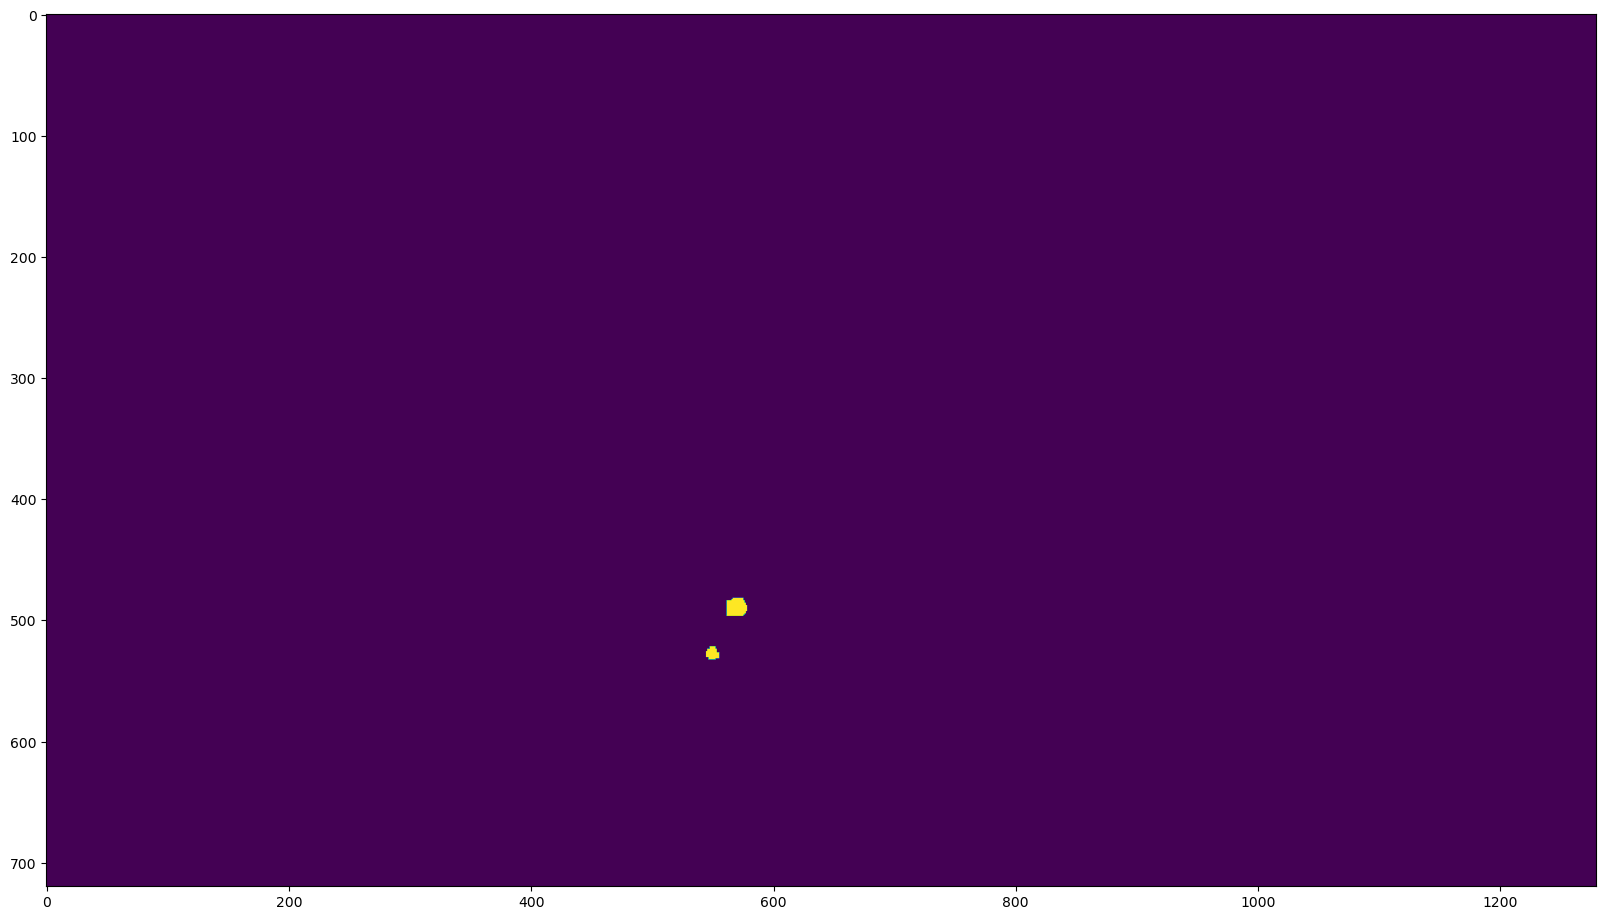

In [14]:
def segment_marker_by_color(frame_tmp):
    # Input must be a frame in the cielab color model from the OpenCV function

    # Extract color channels
    L_channel = frame_tmp[:, :, 0]
    a_channel = frame_tmp[:, :, 1]
    b_channel = frame_tmp[:, :, 2]

    # Color segmentation using NumPy array operations
    marker_blue = (a_channel > 150) & (a_channel < 170) & (b_channel > 90)
    # marker_blue =  (b_channel < 10)
    marker_green = (a_channel < 115) &  (a_channel > 100) & (b_channel > 140)

    marker_pink =   (a_channel < 100) & (b_channel < 140) & (b_channel > 130)
    # marker_yellow = (a_channel > 110) & (a_channel < 120) & (b_channel > 130) & (b_channel < 150)
    marker_yellow =  (a_channel > 100) & (a_channel < 115) &  (b_channel < 110)

    # Remove for prod recording -> now i have only for delete another object
    # marker_blue[600:,:300] = 0
    # marker_pink[600:] = 0
    # marker_green[:,1000:] = 0
    # marker_green[600:,:300] = 0
    # marker_yellow[600:,:300] = 0
    kernel = np.ones((5,5),np.uint8)
    marker_pink = cv2.dilate(np.uint8(marker_pink*255),kernel,iterations = 1)
    marker_green = cv2.dilate(np.uint8(marker_green*255),kernel,iterations = 1)
    marker_yellow = cv2.dilate(np.uint8(marker_yellow*255),kernel,iterations = 1)
    marker_blue = cv2.dilate(np.uint8(marker_blue*255),kernel,iterations = 1)

    return marker_yellow, marker_pink, marker_green,marker_blue, L_channel, a_channel, b_channel
plt.figure(figsize=(20,20))
cielab_frame = cv2.cvtColor(bckp_frame, cv2.COLOR_RGB2Lab)
# Segment markers by color in the CIELAB color space
marker_yellow, marker_pink, marker_green, marker_blue, L , a ,b = segment_marker_by_color(cielab_frame)
plt.figure(figsize=(20,20))
plt.imshow(marker_blue)

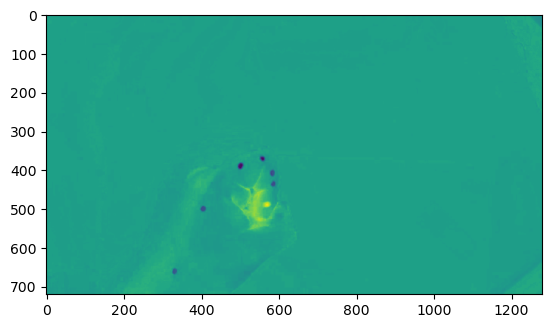

In [15]:
plt.imshow(a)

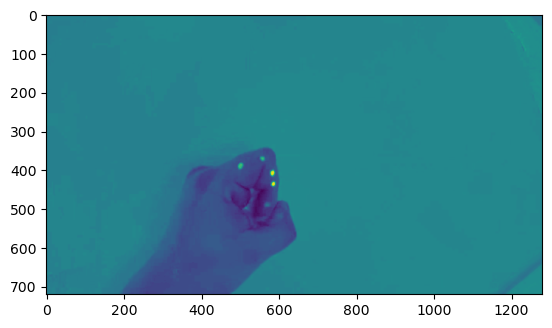

In [16]:
plt.imshow(b)

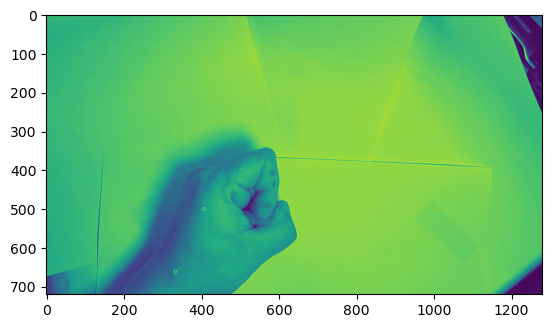

In [17]:
plt.imshow(L)
# plt.imshow(bckp_frame* np.stack([marker_yellow,marker_yellow,marker_yellow] ,axis=2))

## Store processed video

In [18]:
# Store the video with updated frames
output_video_path = os.path.join(output_folder_video,f"{video_name}.mp4")  # Set the desired output video path
store_video(frames_to_store, output_video_path, set_fps)

IndexError: list index out of range

## Store csv - raw_angles

In [19]:
set_fps = 480
df_angle = pd.DataFrame(data=measure, columns=["frame", "angle_0", "angle_1", "angle_2","i_p_0_0_x", "i_p_0_0_y", "i_p_0_x", "i_p_0_y","i_p_1_x", "i_p_1_y","i_p_2_x", "i_p_2_y","i_p_3_x", "i_p_3_y"])
df_angle["time"] = df_angle["frame"] / set_fps
df_angle.to_csv(os.path.join(output_folder_csv,f"{video_name}.csv"), index=False)
df_angle

,frame,angle_0,angle_1,angle_2,i_p_0_0_x,i_p_0_0_y,i_p_0_x,i_p_0_y,i_p_1_x,i_p_1_y,i_p_2_x,i_p_2_y,i_p_3_x,i_p_3_y,time
0,0,152.760279,145.150848,161.911018,328,645,431,502,589,375,673,374,762,409,0.000000
1,1,152.760279,145.150848,163.176450,328,645,431,502,589,375,673,374,762,408,0.002083
2,2,152.760279,145.150848,163.176450,328,645,431,502,589,375,673,374,762,408,0.004167
3,3,152.760279,145.409518,162.917780,328,645,431,502,589,375,673,374,762,408,0.006250
4,4,152.760279,145.409518,162.917780,328,645,431,502,589,375,673,374,762,408,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10313,10313,137.460719,75.356557,175.971736,332,662,405,501,554,366,585,428,588,522,21.485417
10314,10314,136.132541,74.892455,178.058514,332,662,406,501,556,367,585,429,588,523,21.487500
10315,10315,136.132541,74.892455,176.522213,332,662,406,501,556,367,585,429,586,524,21.489583
10316,10316,136.486214,72.434985,177.160786,332,662,406,501,556,367,584,430,583,525,21.491667


In [20]:
df_angle

,frame,angle_0,angle_1,angle_2,i_p_0_0_x,i_p_0_0_y,i_p_0_x,i_p_0_y,i_p_1_x,i_p_1_y,i_p_2_x,i_p_2_y,i_p_3_x,i_p_3_y,time
0,0,152.760279,145.150848,161.911018,328,645,431,502,589,375,673,374,762,409,0.000000
1,1,152.760279,145.150848,163.176450,328,645,431,502,589,375,673,374,762,408,0.002083
2,2,152.760279,145.150848,163.176450,328,645,431,502,589,375,673,374,762,408,0.004167
3,3,152.760279,145.409518,162.917780,328,645,431,502,589,375,673,374,762,408,0.006250
4,4,152.760279,145.409518,162.917780,328,645,431,502,589,375,673,374,762,408,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10313,10313,137.460719,75.356557,175.971736,332,662,405,501,554,366,585,428,588,522,21.485417
10314,10314,136.132541,74.892455,178.058514,332,662,406,501,556,367,585,429,588,523,21.487500
10315,10315,136.132541,74.892455,176.522213,332,662,406,501,556,367,585,429,586,524,21.489583
10316,10316,136.486214,72.434985,177.160786,332,662,406,501,556,367,584,430,583,525,21.491667


In [21]:
measure

[[0,
  152.7602793009207,
  145.15084830393516,
  161.91101781210654,
  328,
  645,
  431,
  502,
  589,
  375,
  673,
  374,
  762,
  409],
 [1,
  152.7602793009207,
  145.15084830393516,
  163.17645013164116,
  328,
  645,
  431,
  502,
  589,
  375,
  673,
  374,
  762,
  408],
 [2,
  152.7602793009207,
  145.15084830393516,
  163.17645013164116,
  328,
  645,
  431,
  502,
  589,
  375,
  673,
  374,
  762,
  408],
 [3,
  152.7602793009207,
  145.40951823732195,
  162.91778019825438,
  328,
  645,
  431,
  502,
  589,
  375,
  673,
  374,
  762,
  408],
 [4,
  152.7602793009207,
  145.40951823732195,
  162.91778019825438,
  328,
  645,
  431,
  502,
  589,
  375,
  673,
  374,
  762,
  408],
 [5,
  152.7602793009207,
  145.40951823732195,
  162.91778019825438,
  328,
  645,
  431,
  502,
  589,
  375,
  673,
  374,
  762,
  408],
 [6,
  152.32949208391204,
  145.84030545433058,
  162.3169211330385,
  328,
  645,
  431,
  502,
  589,
  375,
  673,
  374,
  761,
  408],
 [7,
  152.32